# Isolation by spatial random walks

Here I explore the isolation by resistence [[McRae 2006](https://github.com/jhmarcus/spatial-random-walk/tree/master/ref/mcrae_2006.pdf); [McRae 2007](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/mcrae_beier_2007.pdf)] approximation to expected genetic distances using simulations under the coalescent, following [[Petkova et al. 2016](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/petkova_et_al_2016.pdf)]. I also explore a recent development in the spatial statistics literature, which derives the induced covariance under a spatial-temporal random walk that can be implemented as a simultaneous auto-regressive process (SAR) [[Hanks 2016](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/hanks_2016.pdf)]. This framework allows for an analgous concept of resistence distance on directed graphs which could be of use for inference of asymetric migration in natural systems. See the `../ref` directory for a non-exhausitve list of other relevent papers on this topic.

# Background

## A simultaneous autogressive model for genotype data

Here we follow [[Hanks 2016](https://github.com/jhmarcus/spatial-random-walk/blob/master/ref/hanks_2016.pdf)] but switch up the notation a bit and gloss over most of the theoretical derivations. We also focus on large scale genotype data rather than using a SAR process as a random effect for microsatellite data. First, consider a single SNP $j$ with $\mathbf{y}_j$ carrying the mean centered genotypes of $n$ individuals. We define a dense regular lattice or graph $\mathcal{G}$ over geographic space. For simplicity, lets imagine we sample a single individual from every node on the graph. Let $\mathbf{M}$ be a $n \times n$ matrix storing the edge weights of $\mathcal{G}$. Note that because $\mathcal{G}$ is directed $\mathbf{M}$ is not necessarily symmetric. The exact structure of this lattice will determine what nodes are connected to each other and the magnitude of $m_{ij}$ is reflective of some migration process. In general $\mathbf{M}$  will be very sparse as nodes will only be connected to their neighbors. We define the typical SAR model for the observed genotypes ...


$$
\mathbf{y}_j = \rho\mathbf{W}\mathbf{y}_j + \mathbf{\nu} \\
$$

where $\mathbf{W}$ is the spatial weights matrix, $\rho$ is the autoregressive parameter and $\nu$ is a random effect with $\nu | \mathbf{\Lambda} \sim \mathcal{N}(\nu|\mathbf{0}, \mathbf{\Lambda})$ where $\mathbf{\Lambda}$ is a $n \times n$ diagonal matrix. We can simplify the above equation ...

$$
\mathbf{y}_j - \rho\mathbf{W}\mathbf{y}_j  = \mathbf{\nu} \\
(\mathbf{I} - \rho\mathbf{W})\mathbf{y}_j = \mathbf{\nu} 
$$

Thus as long as $(\mathbf{I} - \rho\mathbf{W})^{-1}$ exsists ...

$$
\mathbf{y}_j = (\mathbf{I} - \rho\mathbf{W})^{-1}\mathbf{\nu }
$$

then ...

$$
\mathbf{y}_j | \mathbf{W}, \mathbf{\Lambda} \sim \mathcal{N}\Big(\mathbf{y}_j | \mathbf{0}, (\mathbf{I} - \rho\mathbf{W})^{-1}\mathbf{\Lambda}(\mathbf{I} - \rho\mathbf{W}^T)^{-1} \big)
$$

If we let $\mathbf{B} = \rho\mathbf{W}$ and set ...

$$
b_{ij} = \frac{m_{ji}}{\sum_{k} m_{ik}}; \lambda_{ii} = \frac{1}{(\sum_{k} m_{ik})^2}
$$

then ...

$$
(\mathbf{L}\mathbf{L}^T)^{-1} = (\mathbf{I} - \mathbf{B})^{-1}\mathbf{\Lambda}(\mathbf{I} - \mathbf{B}^T)^{-1} \Rightarrow
$$

$$
\mathbf{L}\mathbf{L}^T = (\mathbf{I} - \mathbf{B}^T)\mathbf{\Lambda}^{-1}(\mathbf{I} - \mathbf{B})
$$

where $\mathbf{L}$, the graph laplacian of $\mathcal{G}$, can also be written as $\mathbf{L} = \mathbf{D} - \mathbf{M}$ with $\mathbf{D}$ being $n \times n$ diagonal matrix where $d_{ii} = \sum_{k \neq i} m_{ik}$. All of this implies that ...

$$
\mathbf{y}_j | \mathbf{L} \sim \mathcal{N}\big(\mathbf{y}_j | \mathbf{0}, (\mathbf{L}\mathbf{L}^T)^{-1}\big)
$$

We can compute an analogous idea of resistence distance for a directed graph using the covariance defined in the above model. If we let $\mathbf{1}$ be a column vector of size $n$ and $\mathbf{\Sigma} = (\mathbf{L}\mathbf{L}^T)^{-1}$ ...

$$
\tilde{\mathbf{R}} = \mathbf{1}diag(\mathbf{\Sigma})^T + diag(\mathbf{\Sigma})\mathbf{1}^T - 2\mathbf{\Sigma} 
$$

Note that the typical resistence distance for the undirected graph would be computed as ...

$$
\mathbf{R} = \mathbf{1}diag(\mathbf{L})^T + diag(\mathbf{L})\mathbf{1}^T - 2\mathbf{L} 
$$

# Simulations

## Imports / Configuration

Import standand `python` libraries as well as classes defined in `../scripts/` which contain implementations of pieces to the model defined above

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# import helper functions for this notebook see ../scripts
import sys
sys.path.append('../scripts/')
from habitat import Habitat
from stepping_stone import SteppingStone

In [2]:
sns.set_style('white')
plt.style.use('bmh')
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = 8, 6

## Setup the habitat

Here we simulate a habitat as a $8 \times 8$ triangular lattice $\mathcal{G}$. To simulate a barrier we define a quadratic function $f(s)$ of the spatial positions $s$ of each node. $f(s)$ is minimized at the middle of the barrier and the barrier is always set in the center of the habitat. We will consider different migration patterns later.

In [3]:
n = 8 # number of rows in lattice
p = 8 # number of cols in lattice

# define habitat obj
h = Habitat(n, p)

# define migration rate function
def quad_barrier_migration(self, m_min, m_max):
    '''
    Args:
        g: nx.graph
            regular lattice
        s: np.array
            d x 2 array of spatial positions
    Returns:
        g: nx.graph
            regular lattice with assigned weights
    '''
    s0_max = np.max(self.s[:,0])
    s0_med = np.median(self.s[:,0]) + .25
    for i,j in self.g.edges():
        mu = np.mean([self.s[i,0], self.s[j,0]])
        m = (s0_max / s0_med ** 2) * (mu - s0_med) ** 2 + m_min
        self.g[i][j]['m'] = min(m, m_max)
        
    self.m = nx.adjacency_matrix(self.g, weight='m')
    self.m = self.m.toarray()

# assign and compute migration rates
h.mig_rate_func = quad_barrier_migration
h.mig_rate_func(h, .01, 3.)

# compute graph laplacian and resistence / random walk distance
h.compute_graph_laplacian()
h.compute_distances()

The triangular lattice is visualized with edge widths proportional to the defined edge weights, note we multiply the weights by some constant just for visualization purposes. Additional the nodes have a color scheme based on their position on the map, particularly the x position difference is emphasized more than the y.

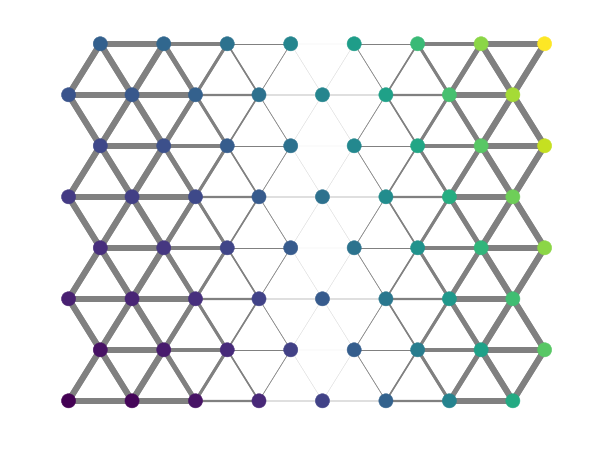

In [4]:
# plot the triangular lattice
h.plot_graph(200, 2, False)

As expected we see that the migration matrix $\mathbf{M}$ is extremley sparse as only neighboring nodes are connected

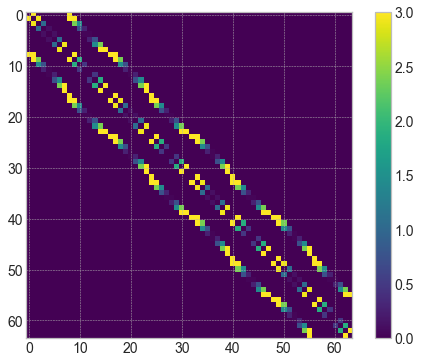

In [5]:
# plot the migration matrix M
h.plot_mig_mat()

## Simulate genotypes

Here we simulate genotypes under the coalescent using [msprime](https://github.com/jeromekelleher/msprime) ... this may take a bit of time. Specifically we simulate 10 haploid individuals per deme in 5000 indepedent regions of the genome. See `../scripts/stepping_stone.py` for default params.

In [6]:
%%time
# simulation object
sim_path = path = '../output/y_barrier_stepping_stone.pkl'
s = SteppingStone(h, sim_path)

CPU times: user 4.92 ms, sys: 15.5 ms, total: 20.4 ms
Wall time: 32.4 ms


In [7]:
# number simulated of haploid individuals and snps
n, p = s.y.shape 
print(n, p)

640 10522


Here we visualize the site frequency spectrum which seems to follow the neutral expectation ... (before when I simulted fewer independent reigions it had an enrichment of common variants as expected). **TODO**: debug this

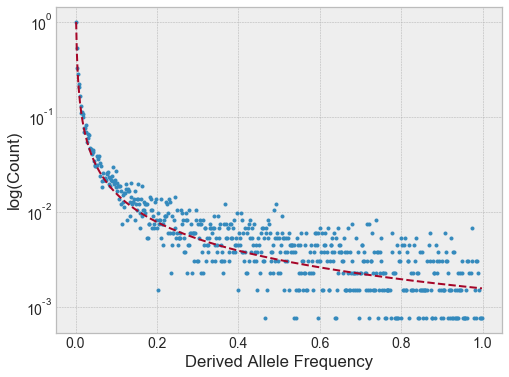

In [8]:
s.plot_sfs()

Lets remove rare variants for subsequent visualization and distance computations

In [9]:
s.filter_rare_var()
print(s.n, s.p)

640 4738


Running PCA on the normalized genotype data, we see a strong signature of the barrier with two clusters based on geographic position on the x axis

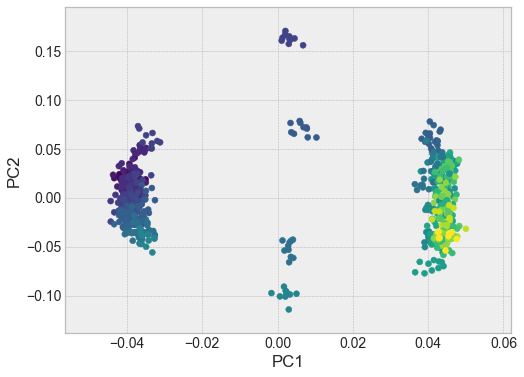

In [10]:
s.plot_pca()

## Computing distances

We can see the graph laplacian is sparse as $\mathbf{M}$ is sparse. We can think of $\mathbf{L}$ here as a sparse presicion matrix.

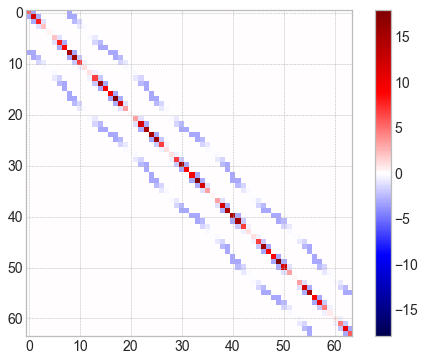

In [11]:
# plot the graph laplacian
h.plot_lapl(h.l)

We can see that $\mathbf{L}\mathbf{L}^T$ is also sparse but not as sparse. It seems to have an additional off-diagonal band.

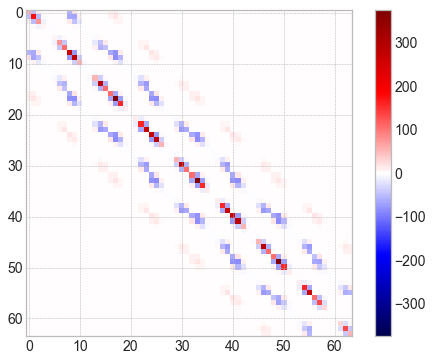

In [12]:
# plot the LL^T where L is the graph laplacian
h.plot_lapl(h.llt)

Plot semivarigoram for different input distances 

geo r2 = 0.5674728750750556
res r2 = 0.7041919899166293
rw r2 = 0.9353953019540248


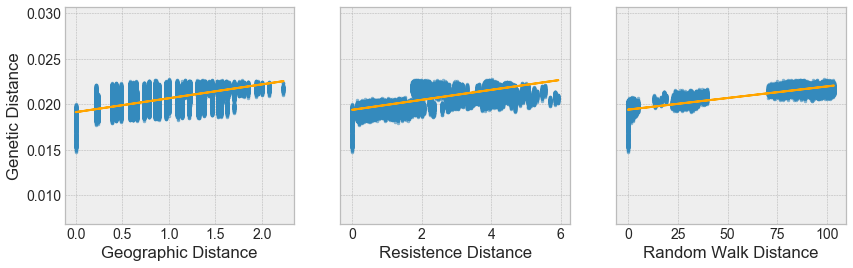

In [13]:
s.compute_distances()
s.plot_distances()

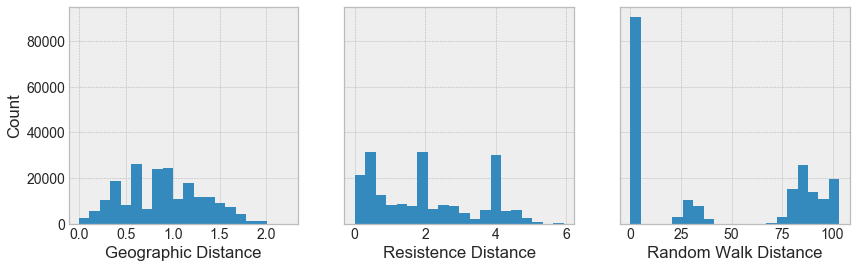

In [14]:
s.plot_dist_hist()

We can see that the random-walk distance has the highest correlation with the genetic distance out of the 3 we compare here. It actually seems suprisingly high. Note that scale of the input distances would be different then the scale of genetic distance. We could add an additional variance parameter to scale the covariance matrix in the likelihood, which will be addressed when thinking about inference under this model. I don't have a good intution for why the correlation would be higher for the "Random Walk Distance" even when simulating under a habitat with an undirected graph. One interesting feature of the "Random Walk Distance" semivariogram is that there seems to be 3 strong modes in the distance. This could make sense given the lattice structure and the simulated migration rates i.e. there are distances to compare accross the barrier, within each region on either side of the barrier and within each deme?